In [1]:
# ignore warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [18]:
#imports
from pathlib import Path
import datetime as dt
import hvplot.pandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geoviews as gv
import geoviews.feature as gf
from geoviews import dim, opts
import altair as alt
from vega_datasets import data
import scipy
from scipy import stats
import yfinance as yf

In [3]:
# import CSVs
inflation_target_year_csv = Path("combined_inflation_cleaned_data.csv")
ibonds_csv = Path("ibonds_cleaned_data.csv")
cpi_csv = Path("cpi_cleaned_data.csv")


# create dfs
combined_df = pd.read_csv(inflation_target_year_csv)
ibonds_combined_df = pd.read_csv(ibonds_csv)
cpi_cpiu_data = pd.read_csv(cpi_csv)


# World Inflation Analyses

### Dot Map

calculations

In [4]:
# isolate 2022 in new df
inflation_target_year_df = combined_df[["latitude", "longitude", "2022"]]
# rename column for map
inflation_target_year_df.rename(columns={"2022":"Inflation Rate (2022)"}, inplace=True)
# drop nulls
inflation_target_year_df.dropna(inplace=True)

# calculate mean inflation overall during a specified time period
mean_world_inflation =  combined_df.iloc[:,-10:]

# find zscores to eliminate outliers that are skewing mean data (by country)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
mean_world_inflation_zscores = abs(scipy.stats.zscore(mean_world_inflation, axis=1, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
mean_world_inflation.mask(mean_world_inflation_zscores > 3, None, inplace=True)

# calculate mean
mean_world_inflation = mean_world_inflation.mean(axis=1, skipna=True)

# add to df
inflation_target_year_df["Mean Inflation"] = mean_world_inflation

# 2022 inflation as percentage of mean
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"] = inflation_target_year_df["Inflation Rate (2022)"] / inflation_target_year_df["Mean Inflation"] * 100

display(inflation_target_year_df.head())

,latitude,longitude,Inflation Rate (2022),Mean Inflation,2022 Inflation Rate Relative to 10-Year Mean Inflation
1,41.153332,20.168331,6.725203,2.254846,298.255466
2,28.033886,1.659626,9.265516,4.807289,192.738884
6,17.060816,-61.796428,7.531078,1.791956,420.271357
8,40.069099,45.038189,8.640911,3.306948,261.295668
10,-25.274398,133.775136,6.594097,2.349890,280.613020


In [5]:
# describe last 20 years of inflation data
stats_df = inflation_target_year_df.iloc[:,-1]
summary_stats = stats_df.describe(include="all")
print(summary_stats)

# fine outliers visually
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"].hvplot.box(ylim=(0,1000))

count     163.000000
mean      356.631191
std       548.986807
min        38.215381
25%       174.164405
50%       268.409884
75%       432.936831
max      6839.405508
Name: 2022 Inflation Rate Relative to 10-Year Mean Inflation, dtype: float64


:BoxWhisker   (2022 Inflation Rate Relative to 10-Year Mean Inflation)

data visualization

In [6]:

map = inflation_target_year_df.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="CartoLight",
    xlabel="longitude",
    ylabel="latitude",
    color="2022 Inflation Rate Relative to 10-Year Mean Inflation",
    clim=(0,800),
    frame_width=800,
    frame_height=400,
    cmap=["#b3f0ff", "#ffffff", "#ffd6cc", "#ff9980", "#ff3300", "#cc2900", "#801a00", "#330a00"],
    line_color="black",
    title="2022 Inflation Rate, Expressed as Percentage of 10-Year Mean",
    hover_cols=["country", "Inflation Rate (2022)"]
)

hvplot.save(map, "high_inflation_world_map.html")

map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (2022 Inflation Rate Relative to 10-Year Mean Inflation,Inflation Rate (2022))

### Heatmap for World Inflation (Percent Change) 1960-2022

calculations

In [7]:
# preview dataframe
display(combined_df.head())

# this automatically changes the df from wide to long
pct_change_world_inflation_df = combined_df

# drop lat/lon
pct_change_world_inflation_df.drop(columns=["latitude", "longitude"], inplace=True)

# limit to ten years
pct_change_world_inflation_df = pct_change_world_inflation_df.iloc[:, -10:]

# find zscores to eliminate outliers that are skewing mean data (by year)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
pct_change_world_inflation_df_zscores = abs(scipy.stats.zscore(pct_change_world_inflation_df, axis=0, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
pct_change_world_inflation_df.mask(pct_change_world_inflation_df_zscores > 3, None, inplace=True)

# calculate mean by year
pct_change_world_inflation_df = pct_change_world_inflation_df.mean()

# change array to df
pct_change_world_inflation_df = pd.DataFrame(pct_change_world_inflation_df)

# name columns
pct_change_world_inflation_df.columns = ["percent change in inflation rate"]

# rename index
pct_change_world_inflation_df.rename_axis("year", inplace=True)

# reset index
pct_change_world_inflation_df.reset_index(inplace=True)

# preview df
display(pct_change_world_inflation_df.head())

,country,latitude,longitude,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,33.939110,67.709953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
1,Albania,41.153332,20.168331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.937621,1.625865,1.896174,1.275432,1.986661,2.028060,1.411091,1.620887,2.041472,6.725203
2,Algeria,28.033886,1.659626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.254239,2.916927,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516
3,American Samoa,-14.270972,-170.132217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,42.546245,1.601554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


,percent change in inflation rate
count,10.000000
mean,4.327162
std,2.215846
min,2.819723
25%,3.392630
50%,3.554264
75%,3.708786
max,10.285945


<Axes: >

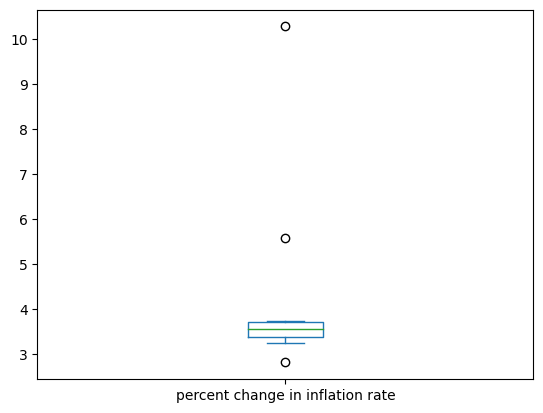

In [8]:
display(pct_change_world_inflation_df.describe())
pct_change_world_inflation_df.plot.box()

heatmap

In [9]:
# attributed resource: https://altair-viz.github.io/gallery/simple_heatmap.html

# create df with necessary data
heatmap_df = pct_change_world_inflation_df

# preview df
display(heatmap_df.head())

# advice from VS error on large datasets 
alt.data_transformers.enable("vegafusion")

# Configure heatmap
base = alt.Chart(heatmap_df, title="Aggregate Inflation Rate Worldwide 2013-2022").encode(
    x="year",
    y="percent change in inflation rate",
)

heatmap = base.mark_rect().encode(
    alt.Color("percent change in inflation rate", title=None)
    # scheme must be vega: https://vega.github.io/vega/docs/schemes/
        .scale(domain=[0, 15],scheme="yelloworangered")
)

# Configure text
text = base.mark_text(baseline="middle").encode(
    alt.Text("percent change in inflation rate", format=".2f"),
    color=alt.condition(
        alt.datum["percent change in inflation rate"],
        alt.value('black'),
        alt.value('black')
    )
)


# Draw the chart
heatmap + text.properties(
    width=800,
    height=400)


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


alt.LayerChart(...)

# Consumer Price Index Analysis

line graph

In [10]:
cpi_plot = cpi_cpiu_data.hvplot(
    x="Label",
    y="Value",
    xticks="Year",
    title="USA Inflation Rate: Consumer Price Index for All Urban Consumers (CPI-U)",
    xlabel="year",
    ylabel="consumer price index",
    color="red",
    width=800,
    height=400
    
    
)

# save as html
hvplot.save(cpi_plot, "inflation_cpiu.html")

cpi_plot

:Curve   [Label]   (Value)

# I Bonds Analysis

### graphs

calculations

In [11]:
# annualize variable interest rate
ibonds_combined_df["annualized six-month variable interest rate"] = np.maximum((ibonds_combined_df["six-month inflation rate"] * 2), 0)

# combined rate
ibonds_combined_df["aggregate annualized interest rate"] = ibonds_combined_df["annualized six-month variable interest rate"] + ibonds_combined_df["fixed rate"]

ibonds_combined_df.head()

,date,fixed rate,six-month inflation rate,annualized six-month variable interest rate,aggregate annualized interest rate
0,09-1998,3.4,0.62,1.24,4.64
1,11-1998,3.3,0.86,1.72,5.02
2,05-1999,3.3,0.86,1.72,5.02
3,11-1999,3.4,1.76,3.52,6.92
4,05-2000,3.6,1.91,3.82,7.42


stacked bar chart

In [12]:
ibonds_bar = ibonds_combined_df.hvplot.bar(
    x="date",
    y=["fixed rate", "annualized six-month variable interest rate"],
    # set ylim to zero because interest cannot be negative on ibonds
    ylim=(0,12),
    stacked=True,
    color=["orange", "red"],
    title="I bonds Aggregate Annualized Interest Rate",
    ylabel="interest rate",
    rot=70,
    xlabel="",
    height=500,
    width=1200
    )

hvplot.save(ibonds_bar, "ibonds_bar.html")

ibonds_bar



:Bars   [date,Variable]   (value)

# Stocks

In [13]:
ClosingPrice = pd.DataFrame()

pd.read_csv("closing_price.csv")

,Date,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2,2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,...,-0.037033,0.009800,0.012437,-0.016090,-0.013629,-0.012676,-0.003297,-0.050068,0.002270,-0.038024
3,2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,...,0.004629,-0.007822,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
4,2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,0.001476,0.011943,-0.002798,-0.001041,0.004477,0.001389,0.008433,0.005023,0.005735,...,-0.006401,0.012852,0.026445,0.011118,-0.000728,0.000621,0.001106,0.002869,0.003521,0.005033
247,2022-12-27,0.002144,-0.014162,-0.013878,-0.000674,-0.020645,0.003605,0.003787,-0.002931,-0.009928,...,0.044723,0.009023,0.013894,0.007540,0.009022,0.007758,0.004657,0.011200,0.008049,-0.003156
248,2022-12-28,-0.009763,-0.016760,-0.030685,-0.004663,-0.011977,-0.006816,-0.016033,-0.008255,-0.020174,...,-0.050279,-0.007203,-0.016426,-0.033988,-0.016077,-0.004542,-0.010135,-0.016574,-0.017813,-0.010117
249,2022-12-29,0.020258,0.030844,0.028324,0.002034,0.033216,0.022999,0.008147,0.019991,0.028173,...,0.014609,0.007085,0.007566,0.046184,0.024784,0.005259,0.014604,0.043307,0.023139,0.030035


In [14]:
#sum the percent change for each stock
sum_percent_change = ClosingPrice.sum()
sum_percent_change


Series([], dtype: float64)

In [15]:
sum_percent_change.dtypes

dtype('float64')

In [16]:
#sort the sum of percent change to locate the top5 stocks
Top5= sum_percent_change.sort_values(ascending=False)
Top5.head(10)

Series([], dtype: float64)

### The top 5 closing prices will be used to compare with Ibonds
* OXY
* CEG
* HES
* APA
* SLB

In [20]:
#Download top 5 stocks 
Top5_stocks = yf.download(['OXY', 'CEG', 'HES', 'APA', 'SLB'], start='2022-01-01' , end = '2022-12-31')['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [21]:
display(Top5_stocks.head())
display(Top5_stocks.tail())

,APA,CEG,HES,OXY,SLB
Date,,,,,
2022-01-03,26.942085,NaN,74.899399,30.439816,30.662964
2022-01-04,28.286308,NaN,79.161819,32.713493,32.151646
2022-01-05,27.268543,NaN,78.839935,31.174835,32.151646
2022-01-06,28.439936,NaN,83.151108,32.105869,32.915318
2022-01-07,28.487944,NaN,84.487389,32.546883,33.862659


,APA,CEG,HES,OXY,SLB
Date,,,,,
2022-12-23,46.110916,86.980537,139.959900,63.197052,51.986076
2022-12-27,46.491516,86.585350,141.668900,63.572578,52.486416
2022-12-28,44.090820,85.567741,136.956818,61.349075,51.603466
2022-12-29,44.803223,85.725822,139.149872,61.546715,51.907593
2022-12-30,45.554661,85.172569,140.098221,62.248360,52.447174


In [22]:
Top5_stocks.describe()

,APA,CEG,HES,OXY,SLB
count,251.000000,240.000000,251.000000,251.000000,251.000000
mean,38.232480,68.140329,111.999554,58.562040,40.624361
std,5.353413,16.583177,17.199369,10.859199,5.994268
min,26.942085,41.020576,74.899399,30.439816,30.490942
25%,33.427929,54.775984,98.791328,55.969244,36.189693
50%,38.628227,62.431683,109.426643,61.090862,38.932892
75%,42.690363,85.181965,124.502495,65.792721,43.698900
max,49.673908,95.990799,147.214630,74.922333,53.598225


### Calculating the cumulative returns and rolling beta for S&P 500 and the Top 5 stocks in S&P 500 basket

In [25]:
# Readimg S&P 500 from closing prices
sp500_cs = Path("SP500_historical.csv")
sp500_df = pd.read_csv(sp500_cs, index_col="Date", parse_dates=True)
sp500_df.sort_index(inplace=True)
sp500_df.head(500)

,Close
Date,
2022-01-03,4796.56
2022-01-04,4793.54
2022-01-05,4700.58
2022-01-06,4696.05
2022-01-07,4677.03
...,...
2022-12-23,3844.82
2022-12-27,3829.25
2022-12-28,3783.22


In [26]:
# Rename `Close` Column to be specific to this portfolio.
sp500_df.columns=["S&P500"]
sp500_df.head(500)

,S&P500
Date,
2022-01-03,4796.56
2022-01-04,4793.54
2022-01-05,4700.58
2022-01-06,4696.05
2022-01-07,4677.03
...,...
2022-12-23,3844.82
2022-12-27,3829.25
2022-12-28,3783.22


In [27]:
df_combined = pd.concat([Top5_stocks, sp500_df], axis='columns')
df_combined.head(500)

,APA,CEG,HES,OXY,SLB,S&P500
Date,,,,,,
2022-01-03,26.942085,NaN,74.899399,30.439816,30.662964,4796.56
2022-01-04,28.286308,NaN,79.161819,32.713493,32.151646,4793.54
2022-01-05,27.268543,NaN,78.839935,31.174835,32.151646,4700.58
2022-01-06,28.439936,NaN,83.151108,32.105869,32.915318,4696.05
2022-01-07,28.487944,NaN,84.487389,32.546883,33.862659,4677.03
...,...,...,...,...,...,...
2022-12-23,46.110916,86.980537,139.959900,63.197052,51.986076,3844.82
2022-12-27,46.491516,86.585350,141.668900,63.572578,52.486416,3829.25
2022-12-28,44.090820,85.567741,136.956818,61.349075,51.603466,3783.22


In [28]:
#Daily returns calculation
d_ret = df_combined.pct_change()

<Axes: title={'center': 'Cumulative ret of Top5 Vs. S&P500'}, xlabel='Date'>

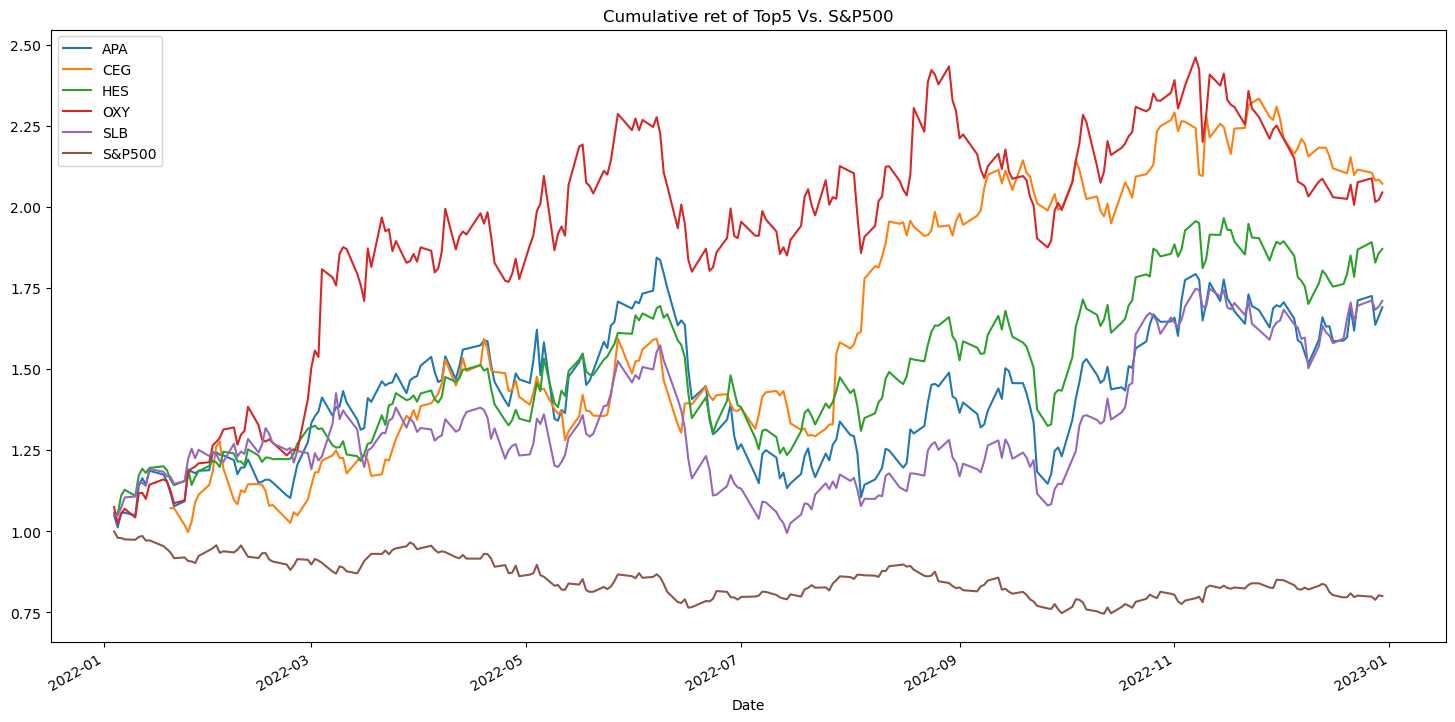

In [29]:
# Calculate cumulative returns of Top5 stocks and the SP500 as benchmark
cumulative_returns = (1 + d_ret).cumprod()
cumulative_returns.head(500)
# Plot cumulative returns
cumulative_returns.plot(figsize=(18,9), title="Cumulative ret of Top5 Vs. S&P500")

<Axes: title={'center': 'Rolling Standard Dev Top5 & S&P500'}, xlabel='Date'>

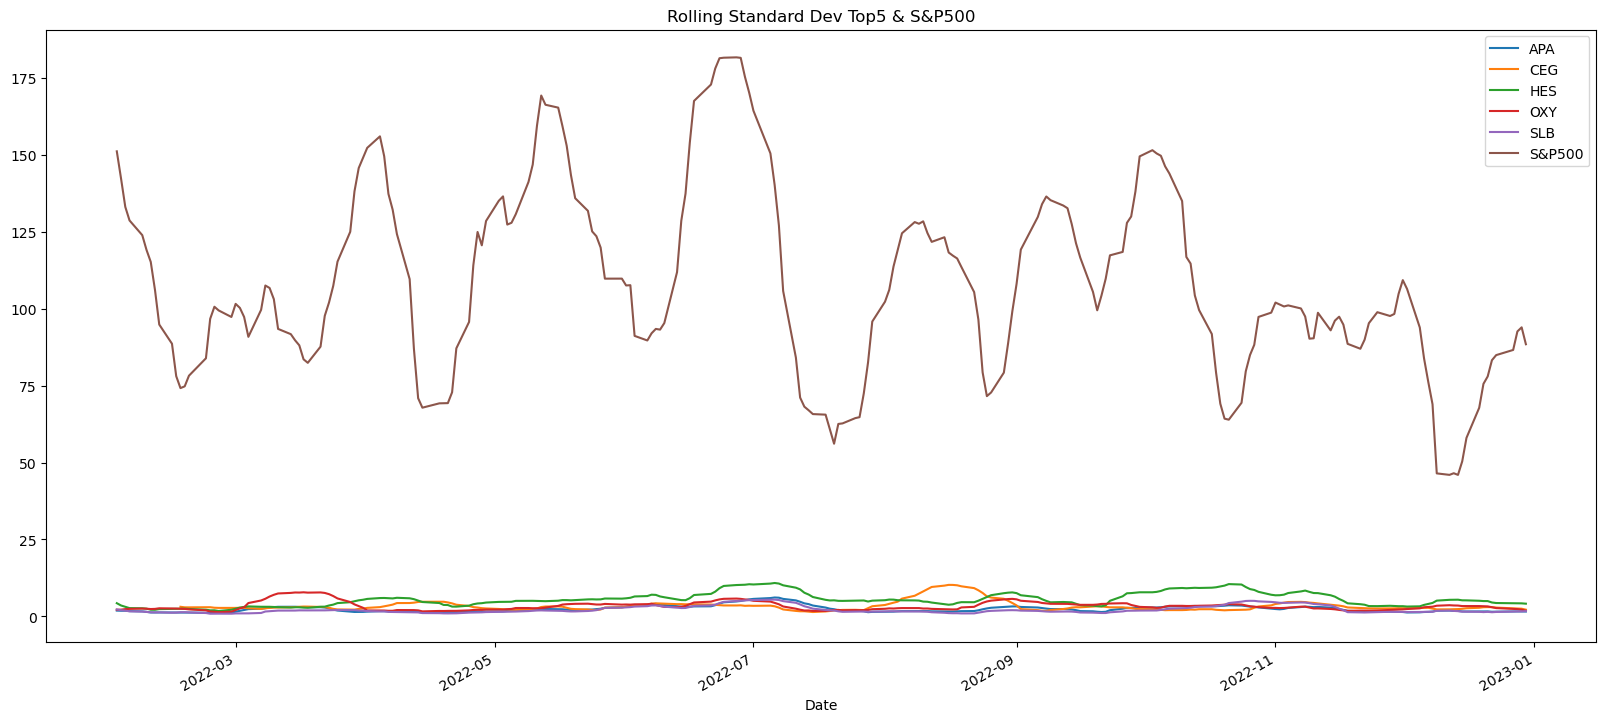

In [30]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
df_combined.rolling(window=21).std()
# Plot the rolling standard deviation
df_combined.rolling(window=21).std().plot(figsize=(20,9), title="Rolling Standard Dev Top5 & S&P500")

#### Sharpe ratio calculation for S&P 500, Ibonds and Top 5 performing stocks in the S&P 500

In [31]:
# read ibond csv file
ibonds_path= Path("ibonds_cleaned_data.csv")
ibonds_df = pd.read_csv(ibonds_path)

In [32]:
#display ibonds data
ibonds_df

,date,fixed rate,six-month inflation rate
0,09-1998,3.4,0.62
1,11-1998,3.3,0.86
2,05-1999,3.3,0.86
3,11-1999,3.4,1.76
4,05-2000,3.6,1.91
5,11-2000,3.4,1.52
6,05-2001,3.0,1.44
7,11-2001,2.0,1.19
8,05-2002,2.0,0.28
9,11-2002,1.6,1.23


In [33]:
# annualize variable interest rate
ibonds_df["annualized six-month variable interest rate"] = np.maximum((ibonds_df["six-month inflation rate"] * 2), 0)

# combined rate
ibonds_df["aggregate annualized interest rate"] = ibonds_df["annualized six-month variable interest rate"] + ibonds_df["fixed rate"]

#locate 2022 risk free rate to compare with stocks
ibonds_df=ibonds_df[48:50]
ibonds_df

,date,fixed rate,six-month inflation rate,annualized six-month variable interest rate,aggregate annualized interest rate
48,05-2022,0.0,4.81,9.62,9.62
49,11-2022,0.4,3.24,6.48,6.88


In [34]:
# drop fixed rate and six-month inflation rate to ease visualization
new_ibondsdf= ibonds_df[ ['date','aggregate annualized interest rate'] ]

In [35]:
new_ibondsdf.head().set_index('date', inplace=True)

<Axes: title={'center': 'Ibonds Interest Rate'}>

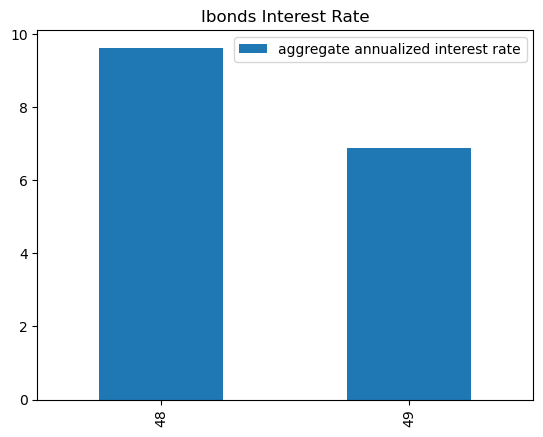

In [36]:
new_ibondsdf.plot(kind='bar', title='Ibonds Interest Rate')

In [37]:
#calculate mean of the annualized risk free rate
rf_rate=ibonds_df['aggregate annualized interest rate'].mean()/100
rf_rate

0.0825

In [38]:
# First, get the  standard deviations of all portfolios
std_dev = df_combined.std()
std_dev

APA         5.353413
CEG        16.583177
HES        17.199369
OXY        10.859199
SLB         5.994268
S&P500    291.830199
dtype: float64

In [39]:
# Calculate the annualized standard deviation using 252 trading days
annual_std = std_dev * np.sqrt(252)
annual_std

APA         84.982790
CEG        263.249769
HES        273.031514
OXY        172.384437
SLB         95.156048
S&P500    4632.660790
dtype: float64

In [40]:
#Calculate the sharpe ratio
#annualized_return=df_combined.mean()
sharpe_ratio = (df_combined.mean() - rf_rate) /annual_std
sharpe_ratio.sort_values(ascending=False)


S&P500    0.884682
APA       0.448914
SLB       0.426057
HES       0.409905
OXY       0.339239
CEG       0.258529
dtype: float64

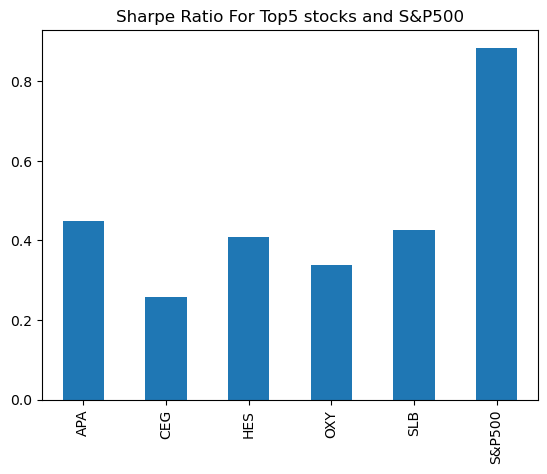

In [41]:
# Now get a graphical representation of the sharpe ratios
plot_2 = sharpe_ratio.plot(kind='bar', title="Sharpe Ratio For Top5 stocks and S&P500")

#### What conclusion can we draw from the sharpe ratios for stocks and Ibonds

We can conclude that the the top 5 stocks from the S&P 500 and the S&P 500 as a whole has higher return reward in comparison with the Ibonds.